In [1]:
import pandas
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import time
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
#from keras.utils import to_categorical
import feather
import random
from datetime import *
import warnings
warnings.filterwarnings("ignore")

C:\Users\aufbpc\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\aufbpc\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\aufbpc\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\aufbpc\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [2]:
FILENAME = "Datasets/final_datasets/merged_data"

In [3]:
data = feather.read_dataframe(f"{FILENAME}.feather")

In [4]:
# Remove those one-hot encoded columns in the dataset created by Abhi

def in_name(c, one_hots):
    for col_name in one_hots:
        if c.startswith(f"{col_name}_"):
            return True
    return False

one_hots = ['Wind_Direction', 'Timezone','State', 'Weather_Condition']
remove = [col for col in data.columns if in_name(col, one_hots)]
df = data.drop(remove, axis=1)


In [5]:
# Remove missing values
df = df.dropna().reset_index(drop=True)
print(len(df))

2922400


In [6]:
df['Severity'] = df['Severity'].astype(int)

# Clean categorical features

### Clean wind direction

* "CALM" = ["Calm", "CALM"]
* "W" = ["W", "West", "WSW", "WNW"] 
* "S" = ["S", "South", "SSW", "SSE"] 
* "N" = ["N", "North", "NNW", "NNE"] 
* "E" = ["E", "East", "ESE", "ENE"]
* "VAR" = ["VAR", "Variable"]

In [7]:
df.loc[df['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
df.loc[(df['Wind_Direction']=='West')|(df['Wind_Direction']=='WSW')|(df['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
df.loc[(df['Wind_Direction']=='South')|(df['Wind_Direction']=='SSW')|(df['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
df.loc[(df['Wind_Direction']=='North')|(df['Wind_Direction']=='NNW')|(df['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
df.loc[(df['Wind_Direction']=='East')|(df['Wind_Direction']=='ESE')|(df['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
df.loc[df['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'
print("Wind Direction after simplification: ", df['Wind_Direction'].unique())

Wind Direction after simplification:  ['SW' 'S' 'W' 'NW' 'N' 'VAR' 'SE' 'E' 'NE' 'CALM']


### Clean weather condition

In [8]:
Counter(df['Weather_Condition'])

Counter({'Overcast': 314137,
         'Mostly Cloudy': 432506,
         'Light Rain': 150052,
         'Light Snow': 46407,
         'Haze': 29015,
         'Scattered Clouds': 170312,
         'Partly Cloudy': 306197,
         'Clear': 597336,
         'Snow': 5176,
         'Light Freezing Drizzle': 716,
         'Fog': 24155,
         'Shallow Fog': 710,
         'Rain': 32900,
         'Heavy Rain': 13063,
         'Light Freezing Rain': 1800,
         'Cloudy': 205447,
         'Smoke': 2831,
         'Patches of Fog': 1487,
         'Mist': 1395,
         'Light Freezing Fog': 478,
         'Light Thunderstorms and Rain': 3807,
         'Light Drizzle': 9415,
         'Thunderstorms and Rain': 1620,
         'Fair': 523539,
         'Blowing Dust / Windy': 115,
         'Widespread Dust': 147,
         'Fair / Windy': 7741,
         'Drizzle': 1197,
         'Light Rain / Windy': 1991,
         'Heavy Drizzle': 162,
         'Showers in the Vicinity': 238,
         'Light Rain wi

https://www.timeanddate.com/weather/glossary.html <br>

**Create features according the different weather conditions** <br>
Scattered clouds, partly cloudy = PARTLY CLOUDY <br>
Overcast, Mostly cloudly, Cloudy = CLOUDY <br>
Fair, Clear = CLEAR <br>
Snow (light snow, heavy snow), and wintry mix  = SNOW <br>
drizzle, light rain/drizzle, light freezing rain/drizzle = LIGHT RAIN <br>
Heavy Rain, heavy thunderstorms, heavy t-storm = HEAVY RAIN <br>
Haze, fog, mist, smoke = fog     *(see https://www.worldatlas.com/articles/what-are-the-differences-between-mist-haze-and-fog.html)*<br>
Rain, light thunderstorms, thunderstorms, t-storm, thunder = RAIN <br>

In [9]:
def get_condition(string):
    
    conditions = ['Clear', 'Partly Cloudy', 'Cloudy', 'Snow', 'Light Rain', 'Heavy Rain', 'Rain', 'Fog'] 
    strings = [['clear', 'fair'],
              ['partly cloudy', 'scattered clouds'],
              ['overcast', 'mostly cloudy', 'cloudy'],
              ['snow', 'wintry mix'],
              ['drizzle', 'light rain', 'light freezing rain'],
              ['heavy rain', 'heavy thunderstorms', 'heavy t-storm'],
              ['rain', 'thunderstorms', 't-storm', 'thunder', 'showers'],
              ['fog', 'haze', 'mist', 'smoke']]

    for j, k in enumerate(strings):
        for val in k:
            if val in string.lower():
                return conditions[j]
    return 'Others'

In [10]:
res = []
for i in df['Weather_Condition'].values:
    res.append(get_condition(i))

df['Condition'] = res
df[['Condition', 'Weather_Condition']]

,Condition,Weather_Condition
0,Cloudy,Overcast
1,Cloudy,Mostly Cloudy
2,Cloudy,Mostly Cloudy
3,Light Rain,Light Rain
4,Cloudy,Overcast
...,...,...
2922395,Clear,Fair
2922396,Clear,Fair
2922397,Partly Cloudy,Partly Cloudy
2922398,Clear,Fair


In [11]:
conditions = ['Clear', 'Partly Cloudy', 'Cloudy', 'Snow', 'Light Rain', 'Heavy Rain', 'Rain', 'Fog', 'Others'] 

for i in conditions:
    print(i, ":")
    print(set(df[df['Condition']==i]['Weather_Condition']))
    print(sum(df['Condition']==i))
    print("\n")
    
df = df[df['Condition']!='Others']

Clear :
{'Fair / Windy', 'Clear', 'Fair'}
1128616


Partly Cloudy :
{'Partly Cloudy / Windy', 'Partly Cloudy', 'Scattered Clouds'}
479226


Cloudy :
{'Mostly Cloudy', 'Overcast', 'Mostly Cloudy / Windy', 'Cloudy', 'Cloudy / Windy'}
960533


Snow :
{'Light Snow', 'Blowing Snow', 'Light Snow / Windy', 'Snow', 'Heavy Snow', 'Snow / Windy', 'Wintry Mix'}
55888


Light Rain :
{'Light Freezing Drizzle', 'Drizzle and Fog', 'Light Rain', 'Light Freezing Rain', 'Light Rain with Thunder', 'Light Drizzle', 'Drizzle', 'Heavy Drizzle', 'Light Rain / Windy'}
168234


Heavy Rain :
{'Heavy Rain', 'Heavy T-Storm', 'Heavy Thunderstorms and Rain', 'Heavy T-Storm / Windy', 'Heavy Rain / Windy'}
17442


Rain :
{'Rain', 'Showers in the Vicinity', 'Thunderstorms and Rain', 'Thunder / Windy', 'Thunder in the Vicinity', 'Light Thunderstorms and Rain', 'Thunderstorm', 'T-Storm', 'T-Storm / Windy', 'Thunder', 'Rain / Windy'}
51435


Fog :
{'Smoke', 'Light Freezing Fog', 'Haze / Windy', 'Shallow Fog', 'Patches of

In [12]:
# One hot encode ['Wind_Direction', 'Timezone', 'State', 'Condition']

one_hots = ['Wind_Direction', 'Timezone','State', 'Condition']
oh = pd.DataFrame()
for c in one_hots:
    dummies = pd.get_dummies(df[c], prefix=c)
    oh = pd.concat([oh, dummies], axis=1)

df = pd.concat([df, oh], axis=1)

In [13]:
# Save this dataframe
df = df.reset_index(drop = True)
df.to_feather("{}_v1.feather".format(FILENAME))

# SHOW CORRELATION BELOW (CHANGE THIS TITLE)

#### With numeric attributes

In [14]:
# Filter the data
#BUM NOEXIT ROUNABOUT GIVEWAY removed due to badly distributed data
df = feather.read_dataframe("{}_v1.feather".format(FILENAME))
drop = ['Unnamed: 0', 'ID', 'Start_Lat', 'Start_Lng', 'Start_Time', 'End_Time', 'Weather_Timestamp', 'Description', 
        'Distance(mi)', 
        'County', 'City', 'Airport_Code', 
        'Wind_Direction', 'Timezone', 'State', 'Condition', 'Weather_Condition',
        'Street', 'Bump', 'No_Exit', 'Roundabout', 'Give_Way', 'Traffic_Calming',
        "Wind_Direction"]

df = df.drop(drop, axis=1).reset_index(drop=True)

# Convert to feather file format
df.to_feather("{}_numeric_v2.feather".format(FILENAME))

In [15]:
del(df)

#### without numeric attributes

In [16]:
# Filter the data
#BUM NOEXIT ROUNABOUT GIVEWAY removed due to badly distributed data
df = feather.read_dataframe("{}_v1.feather".format(FILENAME))
drop = ['Unnamed: 0', 'ID', 'Start_Lat', 'Start_Lng', 'Start_Time', 'End_Time', 'Weather_Timestamp', 'Description', 
        'Distance(mi)', 
        'County', 'City', 'Airport_Code', 
        'Wind_Direction', 'Timezone', 'State', 'Condition', 'Weather_Condition',
        'Street', 'Bump', 'No_Exit', 'Roundabout', 'Give_Way', 'Traffic_Calming',
       'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Population_County', 'Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']

df = df.drop(drop, axis=1).reset_index(drop=True)

# Convert to feather file format
df.to_feather("{}_v2.feather".format(FILENAME))

In [17]:
# Clear memory
del(df)

# Model

In [21]:
#function for removing outliers in numeric data
def outlier_removal(data,columns):
    for col in columns:
        Q1 = np.quantile(data[col].values,0.25)
        Q3 = np.quantile(data[col].values,0.75)
        IQR = Q3-Q1
        
        lower = Q1 - 1.5*IQR
        upper = Q3+ 1.5*IQR
        
        data = data[(data[col]>=lower) & (data[col]<=upper)]
    return data

# Model Function
def Neural_Network(X,labels,neuron_size,epoch_size,k_folds):
    scaler=MinMaxScaler(feature_range=(0,1))
    X = scaler.fit_transform(X)
    
    skf = StratifiedKFold(n_splits=k_folds, random_state=30034, shuffle=True)

    fold_no = 1
    accs = []  # store each accuracy


    for train_index, test_index in skf.split(X, labels):

        # One hot encode labels
        print("FOLD NUMBER = ", str(fold_no))


        X_train = X[train_index]
        X_test = X[test_index]

        y_train = labels[train_index]
        y_test = labels[test_index]

        EPOCHS = epoch_size
        BATCH_SIZE = 128


        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(neuron_size,input_dim=X_train.shape[1], activation='relu'))
        model.add(tf.keras.layers.Dense(int(2/3*neuron_size), activation=tf.nn.leaky_relu))
        model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))
        # Compile model
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
        (test_loss, test_acc) = model.evaluate(X_test, y_test)
        print('Accuracy:', test_acc)
        accs.append(test_acc)

        y_preds = model.predict(X_test)
        p = []
        for i in y_preds:
            p.append(np.argmax(i))

        print("accuracy:", accuracy_score(y_test, p))

        cm=confusion_matrix(y_test,p)
        cm = pd.DataFrame(cm, index = [i for i in "01"],
                          columns = [i for i in "01"])
        cm.index.name = 'Actual'
        cm.columns.name = 'Predicted'
        sns.heatmap(cm, annot=True, 
                    cmap='Blues', cbar=False)
        plt.show()

        print("============================================")
        fold_no+=1

    return accs

### Model evaluation with numeric

FOLD NUMBER =  1
Epoch 1/10
1947713/1947713 [==============================] - 13s 7us/sample - loss: 0.5252 - acc: 0.7204
Epoch 2/10
1947713/1947713 [==============================] - 13s 7us/sample - loss: 0.5150 - acc: 0.7282
Epoch 3/10
1947713/1947713 [==============================] - 13s 7us/sample - loss: 0.5103 - acc: 0.7319
Epoch 4/10
1947713/1947713 [==============================] - 13s 7us/sample - loss: 0.5070 - acc: 0.7343
Epoch 5/10
1947713/1947713 [==============================] - 13s 7us/sample - loss: 0.5045 - acc: 0.7361
Epoch 6/10
1947713/1947713 [==============================] - 13s 7us/sample - loss: 0.5024 - acc: 0.7376
Epoch 7/10
1947713/1947713 [==============================] - 13s 7us/sample - loss: 0.5010 - acc: 0.7388
Epoch 8/10
1947713/1947713 [==============================] - 13s 7us/sample - loss: 0.4999 - acc: 0.7395
Epoch 9/10
1947713/1947713 [==============================] - 13s 7us/sample - loss: 0.4989 - acc: 0.7404
Epoch 10/10
973857/973857 [==

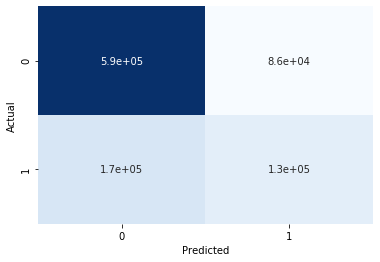

FOLD NUMBER =  2
Epoch 1/10
1947713/1947713 [==============================] - 14s 7us/sample - loss: 0.5240 - acc: 0.7216
Epoch 2/10
1947713/1947713 [==============================] - 13s 7us/sample - loss: 0.5122 - acc: 0.7303
Epoch 3/10
1947713/1947713 [==============================] - 13s 7us/sample - loss: 0.5068 - acc: 0.7346
Epoch 4/10
1947713/1947713 [==============================] - 13s 7us/sample - loss: 0.5039 - acc: 0.7368
Epoch 5/10
1947713/1947713 [==============================] - 13s 7us/sample - loss: 0.5017 - acc: 0.73840s - loss: 0.5017 
Epoch 6/10
1947713/1947713 [==============================] - 13s 7us/sample - loss: 0.4999 - acc: 0.7400
Epoch 7/10
1947713/1947713 [==============================] - 13s 7us/sample - loss: 0.4986 - acc: 0.7406
Epoch 8/10
1947713/1947713 [==============================] - 13s 7us/sample - loss: 0.4975 - acc: 0.7413
Epoch 9/10
1947713/1947713 [==============================] - 13s 7us/sample - loss: 0.4966 - acc: 0.7419
Epoch 10/10

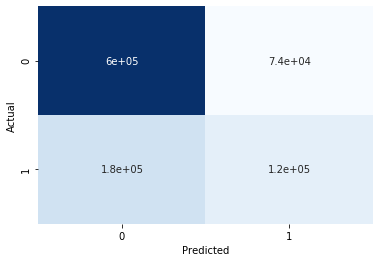

FOLD NUMBER =  3
Epoch 1/10
1947714/1947714 [==============================] - 14s 7us/sample - loss: 0.5258 - acc: 0.7202
Epoch 2/10
1947714/1947714 [==============================] - 14s 7us/sample - loss: 0.5129 - acc: 0.7297
Epoch 3/10
1947714/1947714 [==============================] - 14s 7us/sample - loss: 0.5068 - acc: 0.7344
Epoch 4/10
1947714/1947714 [==============================] - 14s 7us/sample - loss: 0.5035 - acc: 0.7365
Epoch 5/10
1947714/1947714 [==============================] - 14s 7us/sample - loss: 0.5012 - acc: 0.7384
Epoch 6/10
1947714/1947714 [==============================] - 14s 7us/sample - loss: 0.4996 - acc: 0.7390
Epoch 7/10
1947714/1947714 [==============================] - 14s 7us/sample - loss: 0.4984 - acc: 0.7403
Epoch 8/10
1947714/1947714 [==============================] - 14s 7us/sample - loss: 0.4975 - acc: 0.7409
Epoch 9/10
1947714/1947714 [==============================] - 14s 7us/sample - loss: 0.4967 - acc: 0.7414
Epoch 10/10
973856/973856 [==

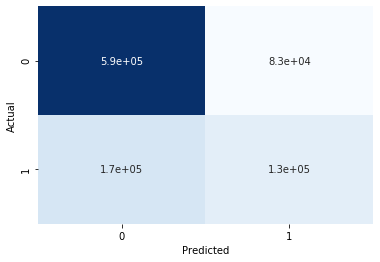

Fold  1  Accuracy:  0.7401857
Fold  2  Accuracy:  0.7409681
Fold  3  Accuracy:  0.74279565
Average Accuracy:  0.7413165


In [22]:
data = feather.read_dataframe("{}_numeric_v2.feather".format(FILENAME))
data['Grouped_Severity'] = np.where(data['Severity']<=2, 0, 1)
labels = data['Grouped_Severity']
X = data.drop(['Severity',"Grouped_Severity"], axis=1)

accuracies = Neural_Network(X,labels,50,10,3)
for i in range(1,4):
    print("Fold ",i," Accuracy: ",accuracies[i-1])
print("Average Accuracy: ",np.mean(accuracies))

### Model evaluation without numeric

In [ ]:
data = feather.read_dataframe("{}_v2.feather".format(FILENAME))
data['Grouped_Severity'] = np.where(data['Severity']<=2, 0, 1)   
labels = data['Grouped_Severity']
X = data.drop(['Severity',"Grouped_Severity"], axis=1)

accuracies = Neural_Network(X,labels,50,10,3)
for i in range(1,4):
    print("Fold ",i," Accuracy: ",accuracies[i])
print("Average Accuracy: ",np.mean(accuracies))

### Finding best neuron size

In [ ]:
data = feather.read_dataframe("{}_numeric_v2.feather".format(FILENAME))

data['Grouped_Severity'] = np.where(data['Severity']<=2, 0, 1)    
y = data['Grouped_Severity']
X = data.drop(['Severity',"Grouped_Severity"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=30034)

max_neurons = X_train.shape[1]
neuron_size = range(max_neurons,4,-10)

accs = []

for i in neuron_size:
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(i,input_dim=X_train.shape[1], activation='relu'))
    model.add(tf.keras.layers.Dense(int(2/3*i), activation=tf.nn.leaky_relu))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=10, batch_size=128)
    (test_loss, test_acc) = model.evaluate(X_test, y_test)
    print('Accuracy:', test_acc)
    accs.append(test_acc)

#plotting line graph of accuracy vs neuron_size
sns.set_style("darkgrid")
plt.plot(neuron_size, accuracies, label="Accuracy")

    
best_neuron_size = neuron_size[np.argmax(accs)]

### Performing  outlier removal

In [ ]:
data = feather.read_dataframe("{}_numeric_v2.feather".format(FILENAME))

numeric_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
        'Wind_Speed(mph)', 'Precipitation(in)',
       'Population_County', 'Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']
data = outlier_removal(data,numeric_cols).reset_index(drop = True)

In [ ]:
#Boxplot after outlier removal
cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
        'Wind_Speed(mph)', 'Precipitation(in)',
       'Population_County', 'Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']

sns.set_style('darkgrid')
f, axes = plt.subplots(6,2, figsize=(15,20))
y = 0;
for name in cols[1:]:
    i, j = divmod(y, 2)
    sns.boxplot(x=data[name], ax=axes[i, j])
    y = y+1

plt.tight_layout()
plt.show()

In [ ]:
data['Grouped_Severity'] = np.where(data['Severity']<=2, 0, 1)
labels = data['Grouped_Severity']
#dropping percipitation and visibility due to all values removed as outliers
X = data.drop(['Severity',"Grouped_Severity",'Precipitation(in)','Visibility(mi)'], axis=1)

accuracies = Neural_Network(data,labels,best_neuron_size,20,5)
for i in range(1,4):
    print("Fold ",i," Accuracy: ",accuracies[i])
print("Average Accuracy: ",np.mean(accuracies))